In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Neo4j v2.0.1

**Descarga**
- [Descargar Neo4j Desktop v2.0.1 (macOS)](https://neo4j.com/download/neo4j-desktop/?edition=desktop&flavour=osx&release=2.0.1&offline=false)

**Configuración**
1. Instalar Neo4j Desktop.
2. Abrir la app y crear un nuevo proyecto con "Add".
3. Dentro del proyecto, seleccionar "Add Graph" → "Local DBMS".
4. Configurar:
   - Name: `BDNR_ml-25m`
   - Password: `bdnr2025`
   - Versión usada: `2025.05.0`
5. Hacer clic en "Create".

**Conexión**
```
neo4j://127.0.0.1:7687
```

In [21]:
import json
from src.benchmark.utils import get_system_info
import neo4j

print("neo4j Version:", neo4j.__version__)
print("System Info:\n", json.dumps(get_system_info(), indent=3))

neo4j Version: 5.28.1
System Info:
 {
   "python_version": "3.12.1",
   "system": {
      "os": "Darwin",
      "release": "24.5.0",
      "machine": "x86_64",
      "processor": "i386"
   },
   "cpu": {
      "physical_cores": 8,
      "total_cores": 8,
      "frequency_mhz": 2400
   },
   "memory": {
      "total_ram_gb": 16.0,
      "available_ram_gb": 0.73
   }
}


# Data Load

In [22]:
from neo4j import GraphDatabase

uri = "bolt://localhost:7687"  
user = "neo4j"
password = "bdnr2025" 

driver = GraphDatabase.driver(uri, auth=(user, password))
session = driver.session()

In [23]:
try:
    session.run("RETURN 1").single()
    print("Successfully connected to Neo4j")
except Exception as e:
    print(f"Connection failed: {e}")

Successfully connected to Neo4j


In [35]:
databases = session.run("SHOW DATABASES").data()
print("Databases:", [db["name"] for db in databases])

Databases: ['neo4j', 'system']


In [36]:
from pprint import pprint

result = session.run("SHOW DATABASES").data()
for db in result:
    print(f"\n{db['name']}")
    pprint(db, indent=2, width=100, depth=3, sort_dicts=False)


neo4j
{ 'name': 'neo4j',
  'type': 'standard',
  'aliases': [],
  'access': 'read-write',
  'address': 'localhost:7687',
  'role': 'primary',
  'writer': True,
  'requestedStatus': 'online',
  'currentStatus': 'online',
  'statusMessage': '',
  'default': True,
  'home': True,
  'constituents': []}

system
{ 'name': 'system',
  'type': 'system',
  'aliases': [],
  'access': 'read-write',
  'address': 'localhost:7687',
  'role': 'primary',
  'writer': True,
  'requestedStatus': 'online',
  'currentStatus': 'online',
  'statusMessage': '',
  'default': False,
  'home': False,
  'constituents': []}


### Batch Load: UNWIND & MERGE

In [26]:
import pandas as pd

# Read CSV files
base_path = "/Users/efaliveni//Downloads/ml-25m"

ratings = pd.read_csv(f"{base_path}/ratings.csv")
movies = pd.read_csv(f"{base_path}/movies.csv")
tags = pd.read_csv(f"{base_path}/tags.csv")
genome_tags = pd.read_csv(f"{base_path}/genome-tags.csv")
genome_scores = pd.read_csv(f"{base_path}/genome-scores.csv")

In [37]:
# Filter Data
SAMPLE_SIZE = 2025

selected_users = ratings['userId'].unique()[:SAMPLE_SIZE]
filtered_ratings = ratings[ratings['userId'].isin(selected_users)]
filtered_movie_ids = filtered_ratings['movieId'].unique()
filtered_movies = movies[movies['movieId'].isin(filtered_movie_ids)].copy()
filtered_tags = tags[tags['movieId'].isin(filtered_movie_ids)]
filtered_scores = genome_scores[genome_scores['movieId'].isin(filtered_movie_ids)]

In [38]:
from collections import defaultdict
# Create a dictionary of genome tags for quick lookup
genome_tags_dict = {row['tagId']: row['tag'] for _, row in genome_tags.iterrows()}

# Build dictionaries to accumulate data
ratings_by_movie = defaultdict(list)
scores_by_movie = defaultdict(list)

ratings_by_user = defaultdict(list)
tags_by_user = defaultdict(list)

In [39]:
# Process ratings and tags to build both movie and user views
RELEVANCE_THRESHOLD = 0.8

# Ratings
for _, r in filtered_ratings.iterrows():
    movie_id = int(r.movieId)
    user_id = int(r.userId)
    
    # Add to movie's ratings
    ratings_by_movie[movie_id].append({
        "userId": user_id,
        "rating": float(r.rating),
        "timestamp": int(r.timestamp)
    })
    
    # Add to user's ratings
    ratings_by_user[user_id].append({
        "movieId": movie_id,
        "rating": float(r.rating),
        "timestamp": int(r.timestamp)
    })
    
# Tags (only for users), genome tag is the cleaned infered tag
for _, t in filtered_tags.dropna(subset=["tag"]).iterrows():
    movie_id = int(t.movieId)
    user_id = int(t.userId)
    
    tags_by_user[user_id].append({
        "movieId": movie_id,
        "tag": t.tag,
        "timestamp": int(t.timestamp)
    })
    
# Genome scores (only for movies), with 0.8 threshold
for _, s in filtered_scores[filtered_scores.relevance > RELEVANCE_THRESHOLD].iterrows():
    movie_id = int(s.movieId)
    tag_id = int(s.tagId)
    
    scores_by_movie[movie_id].append({
        "tagId": tag_id,
        "tag": genome_tags_dict.get(tag_id, ""),
        "relevance": float(s.relevance)
    })

In [40]:
import re

# Build movie documents
movie_docs = []
for _, m in filtered_movies.iterrows():
    movie_id = int(m.movieId)
   
    # Extract year from title
    title = m.title
    year_match = re.search(r"\((\d{4})\)$", title)
    year = int(year_match.group(1)) if year_match else None
    
    # Get ratings and tags for this movie
    movie_ratings = ratings_by_movie.get(movie_id, [])
    tag_entries = scores_by_movie.get(movie_id, [])
    
    # Calculate statistics
    rating_count = len(movie_ratings)
    if rating_count > 0:
        avg_rating = sum(r['rating'] for r in movie_ratings) / rating_count
        # Calculate rating distribution (count of each star rating)
        rating_dist = {"0.5":0, "1.0":0, "1.5":0, "2.0":0, "2.5":0, 
                      "3.0":0, "3.5":0, "4.0":0, "4.5":0, "5.0":0}
        for r in movie_ratings:
            rating_key = f"{r['rating']}"
            rating_dist[rating_key] += 1 
    else:
        avg_rating = 0.0
        rating_dist = {}  # will result in empty arrays below

    # Neo4j only allows:
    # - Single values: string, int, float, boolean, datetime
    # - Arrays of primitive types: [int], [string], etc.
    dist_keys = list(rating_dist.keys()) if rating_dist else []
    dist_values = list(rating_dist.values()) if rating_dist else []
    
    tag_ids = [int(e["tagId"]) for e in tag_entries]
    tag_relevances = [float(e["relevance"]) for e in tag_entries]
    tag_names = [str(e["tag"]) for e in tag_entries]
    
    movie_docs.append({
        "movieId": movie_id,
        "title": title,
        "year": year,
        "genres": m.genres.split("|") if pd.notna(m.genres) else [],
        "ratingCount": rating_count,
        "avgRating": avg_rating,
        "ratingDistKeys": dist_keys,
        "ratingDistValues": dist_values,
        "tagIds": tag_ids,
        "tagRelevances": tag_relevances,
        "tagNames": tag_names
    })

In [41]:
user_docs = []

for user_id in selected_users:
    user_id = int(user_id)

    user_ratings = ratings_by_user.get(user_id, [])
    user_tags = tags_by_user.get(user_id, [])
    
    # Rating stats
    rating_count = len(user_ratings)
    avg_rating = sum(r['rating'] for r in user_ratings) / rating_count if rating_count > 0 else 0.0
    
    # Sort ratings by timestamp
    user_ratings.sort(key=lambda r: r['timestamp'])

    # Flatten ratings for Neo4j
    rated_movie_ids = [r['movieId'] for r in user_ratings]
    rated_scores = [r['rating'] for r in user_ratings]
    rated_timestamps = [r['timestamp'] for r in user_ratings]

    # (Optional future support for tags)
    # tag_movie_ids = [t['movieId'] for t in user_tags]
    # tag_labels = [t['tag'] for t in user_tags]
    # tag_timestamps = [t['timestamp'] for t in user_tags]

    user_docs.append({
        "userId": user_id,
        "ratingCount": rating_count,
        "avgRating": round(avg_rating, 2),
        "ratedMovieIds": rated_movie_ids,
        "ratedScores": rated_scores,
        "ratedTimestamps": rated_timestamps,
        # "tagMovieIds": tag_movie_ids,
        # "tagLabels": tag_labels,
        # "tagTimestamps": tag_timestamps
    })


In [42]:
from neo4j import Session

def load_users(session: Session, user_data: list, batch_size: int = 1000) -> None:
    """Creates User nodes with rating history embedded as arrays."""
    
    query = """
    UNWIND $batch AS user
    MERGE (u:User {userId: user.userId})
    SET u.ratingCount = user.ratingCount,
        u.avgRating = user.avgRating,
        u.ratedMovieIds = user.ratedMovieIds,
        u.ratedScores = user.ratedScores,
        u.ratedTimestamps = user.ratedTimestamps
    """

    if batch_size is None:
        batch_size = len(user_data)

    for i in range(0, len(user_data), batch_size):
        batch = user_data[i:i + batch_size]
        session.run(query, batch=batch)


def load_movies(session: Session, movie_data: list, batch_size: int = 1000) -> None:
    """Creates Movie nodes with embedded genome tags (tagGenome)."""
         
    # Cypher query to store Movie nodes with embedded data
    query = """
    UNWIND $batch AS movie
    MERGE (m:Movie {movieId: movie.movieId})
    SET m.title = movie.title,
        m.year = movie.year,
        m.genres = movie.genres,
        m.ratingCount = movie.ratingCount,
        m.avgRating = movie.avgRating,
        m.ratingDistKeys = movie.ratingDistKeys,
        m.ratingDistValues = movie.ratingDistValues,        
        m.tagIds = movie.tagIds,
        m.tagRelevances = movie.tagRelevances,
        m.tagNames = movie.tagNames
    """
    
    if batch_size is None:
        batch_size = len(movie_data)

    for i in range(0, len(movie_data), batch_size):
        batch = movie_data[i:i + batch_size]
        session.run(query, batch=batch)


def load_ratings(session: Session, ratings_df: pd.DataFrame, batch_size: int = 1000) -> None:
    """Creates User and Movie nodes with RATED relationships."""
    rating_data = ratings_df.to_dict("records")
    
    query = """
    UNWIND $batch AS row
    MERGE (u:User {userId: row.userId})
    MERGE (m:Movie {movieId: row.movieId})
    MERGE (u)-[r:RATED]->(m)
    SET r.rating = row.rating, 
        r.timestamp = row.timestamp
    """
   
    if batch_size is None:
        batch_size = len(ratings_df)
    
    # Process in batches to avoid memory issues
    for i in range(0, len(rating_data), batch_size):
        batch = rating_data[i:i + batch_size]
        session.run(query, batch=batch)

def load_tags(session: Session, tags_df: pd.DataFrame, batch_size: int = 1000) -> None:
    """Creates TAGGED relationships between existing Users and Movies"""
    # Clean data - remove null tags
    tag_data = tags_df.dropna(subset=["tag"]).to_dict("records")
    
    query = """
    UNWIND $batch AS row
    MATCH (u:User {userId: row.userId})
    MATCH (m:Movie {movieId: row.movieId})
    MERGE (u)-[t:TAGGED]->(m)
    SET t.tag = row.tag
    """
       
    if batch_size is None:
        batch_size = len(tags_df)
        
    for i in range(0, len(tag_data), batch_size):
        batch = tag_data[i:i + batch_size]
        session.run(query, batch=batch)

In [43]:
result = session.run("MATCH (n) DETACH DELETE n")
summary = result.consume()

print("Query summary:")
print(f"Nodes deleted: {summary.counters.nodes_deleted}")
print(f"Relationships deleted: {summary.counters.relationships_deleted}")

Query summary:
Nodes deleted: 22824
Relationships deleted: 0


In [44]:
import time

start_time = time.time()

stats = {
    'movies_loaded': 0,
    'users_loaded': 0,
    'rates_created': 0,
    'tags_created': 0,
    'execution_time': 0
}

BATCH_SIZE = None

# Insert data
try:
    print("Starting data loading process...")
    
    # Load users (foundational nodes)
    print("\nLoading users...")
    user_start = time.time()
    load_users(session, user_docs, BATCH_SIZE)
    stats['users_loaded'] = len(user_docs)
    print(f"Users loaded in {time.time() - user_start:.2f}s")
    
    # Load movies (foundational nodes)
    print("\nLoading movies...")
    movie_start = time.time()
    load_movies(session, movie_docs, BATCH_SIZE)
    stats['movies_loaded'] = len(movie_docs)
    print(f"Movies loaded in {time.time() - movie_start:.2f}s")
    
    # Load users through ratings
    print("\nLoading ratings...")
    ratings_start = time.time()
    load_ratings(session, filtered_ratings, BATCH_SIZE)
    stats['rates_created'] = len(filtered_ratings)
    print(f"Ratings loaded in {time.time() - ratings_start:.2f}s")
    
    # Load tags
    print("\nLoading tags...")
    tags_start = time.time()
    load_tags(session, filtered_tags, BATCH_SIZE)
    stats['tags_created'] = len(filtered_tags)
    print(f"Tags loaded in {time.time() - tags_start:.2f}s")

except Exception as e:
    print(f"\nError during data loading: {str(e)}")
    raise
finally:
    stats['execution_time'] = time.time() - start_time
    print(f"\nTotal processing time: {stats['execution_time']:.2f} seconds")
    print(f"Summary: {stats}")

Starting data loading process...

Loading users...
Users loaded in 2.39s

Loading movies...
Movies loaded in 26.47s

Loading ratings...
Ratings loaded in 666.60s

Loading tags...
Tags loaded in 274.78s

Total processing time: 970.24 seconds
Summary: {'movies_loaded': 14619, 'users_loaded': 2025, 'rates_created': 293308, 'tags_created': 924902, 'execution_time': 970.2448470592499}


### Sample Movie

In [45]:
query = """
MATCH (m:Movie)
RETURN m
LIMIT 1
"""

result = session.run(query)

for record in result:
    movie_node = record["m"]
    pprint(dict(movie_node), width=200, compact=True)

{'avgRating': 3.932142857142857,
 'genres': ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'],
 'movieId': 1,
 'ratingCount': 700,
 'ratingDistKeys': ['0.5', '1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0'],
 'ratingDistValues': [4, 8, 4, 20, 18, 108, 65, 230, 70, 173],
 'tagIds': [29, 63, 64, 186, 193, 203, 204, 215, 244, 278, 309, 310, 374, 412, 414, 445, 464, 469, 497, 536, 588, 589, 603, 717, 742, 785, 786, 971, 1036, 1062],
 'tagNames': ['adventure', 'animated', 'animation', 'cartoon', 'cgi', 'childhood', 'children', 'classic', 'computer animation', 'cute', 'disney', 'disney animated feature', 'family', 'friendship',
              'fun', 'good', 'great', 'great movie', 'heartwarming', 'imdb top 250', 'kids', 'kids and family', 'light', 'nostalgic', 'original', 'pixar', 'pixar animation', 'story', 'toys',
              'unlikely friendships'],
 'tagRelevances': [0.89375, 0.94725, 0.98425, 0.95475, 0.8145, 0.90375, 0.95975, 0.815, 0.99875, 0.8420000000000001,

### Sample User

In [46]:
query = """
MATCH (u:User)
RETURN u
LIMIT 1
"""

result = session.run(query)

for record in result:
    user_node = record["u"]
    pprint(dict(user_node), width=200, compact=True) 

{'avgRating': 3.81,
 'ratedMovieIds': [5952, 2012, 2011, 1653, 1250, 6539, 6377, 3448, 1088, 899, 4308, 2161, 6711, 3949, 8360, 5878, 306, 1175, 307, 1237, 7327, 8154, 7234, 2843, 4144, 7365, 2068, 4422, 4973, 6016,
                   8873, 2692, 27721, 7323, 6954, 8014, 7939, 6370, 8973, 4703, 31956, 5147, 8786, 1260, 2351, 7940, 7209, 8685, 7820, 7937, 7938, 8405, 4325, 2632, 1217, 8729, 5912, 5767, 665, 2573,
                   27266, 8327, 32591, 5269, 3569, 27193, 5684, 7318, 296, 7361],
 'ratedScores': [4.0, 2.5, 2.5, 4.0, 4.0, 3.5, 4.0, 4.0, 4.0, 3.5, 3.0, 3.5, 5.0, 5.0, 4.0, 4.0, 3.5, 3.5, 5.0, 5.0, 3.5, 5.0, 4.5, 4.5, 5.0, 4.0, 2.5, 3.0, 4.5, 5.0, 3.0, 5.0, 3.0, 3.5, 3.5, 3.5,
                 2.5, 4.5, 4.0, 4.0, 3.5, 4.0, 4.0, 3.5, 4.5, 4.5, 4.0, 1.0, 2.5, 3.0, 2.5, 3.5, 5.0, 5.0, 3.5, 3.5, 3.0, 5.0, 5.0, 4.0, 4.5, 5.0, 5.0, 0.5, 5.0, 3.0, 2.0, 2.0, 5.0, 5.0],
 'ratedTimestamps': [1147868053, 1147868068, 1147868079, 1147868097, 1147868414, 1147868461, 1147868469, 1147868480, 

# Single-Threaded Benchmark
Simulate User Load, real time latency stress

In [47]:
from neo4j import Session
from typing import Union

def print_plan_tree(plan: Union[dict, object], indent=0):
    prefix = "  " * indent
    if isinstance(plan, dict):
        operator = plan.get("operatorType", "Unknown")
        arguments = plan.get("args", plan.get("arguments", {}))
        children = plan.get("children", [])
    else:
        operator = plan.operator_type
        arguments = plan.arguments
        children = plan.children

    print(f"{prefix}- Operator: {operator}")
    for key, value in arguments.items():
        print(f"{prefix}    {key}: {value}")

    for child in children:
        print_plan_tree(child, indent + 1)

def explain_query_plan(session: Session):
    result = session.run("""
        EXPLAIN
        MATCH (m:Movie {movieId: $id})
        RETURN m
        LIMIT 1
    """, id=8977)

    summary = result.consume()
    plan = summary.plan  # This may be a dict depending on driver version

    print("Logical Query Plan:\n" + "-"*40)
    print_plan_tree(plan)

explain_query_plan(session)

Logical Query Plan:
----------------------------------------
- Operator: ProduceResults@neo4j
    planner-impl: IDP
    string-representation: Cypher 5

Planner COST

Runtime PIPELINED

Runtime version 2025.05

Batch size 128

+------------------+----+-----------------+----------------+---------------------+
| Operator         | Id | Details         | Estimated Rows | Pipeline            |
+------------------+----+-----------------+----------------+---------------------+
| +ProduceResults  |  0 | m               |              1 |                     |
| |                +----+-----------------+----------------+                     |
| +Limit           |  1 | 1               |              1 |                     |
| |                +----+-----------------+----------------+                     |
| +Filter          |  2 | m.movieId = $id |              1 |                     |
| |                +----+-----------------+----------------+                     |
| +NodeByLabelScan |  3 | 

In [48]:
from typing import Union

def print_profile_tree(plan: Union[dict, object], indent=0):
    prefix = "  " * indent

    # Handle dict-style plan (fallback)
    if isinstance(plan, dict):
        operator = plan.get("operatorType", "Unknown")
        arguments = plan.get("args", plan.get("arguments", {}))
        children = plan.get("children", [])
        records = plan.get("records", "?")
        db_hits = plan.get("dbHits", "?")
    else:
        operator = plan.operator_type
        arguments = plan.arguments
        children = plan.children
        records = getattr(plan, "records", "?")
        db_hits = getattr(plan, "db_hits", "?")

    print(f"{prefix}- Operator: {operator}")
    for key, value in arguments.items():
        print(f"{prefix}    {key}: {value}")
    print(f"{prefix}    Rows: {records}")
    print(f"{prefix}    DB Hits: {db_hits}")

    for child in children:
        print_profile_tree(child, indent + 1)

def profile_query_plan(session: Session):
    result = session.run("""
        PROFILE
        MATCH (m:Movie {movieId: $id})
        RETURN m
        LIMIT 1
    """, id=123)

    summary = result.consume()
    plan = summary.profile

    print("Physical Execution Plan with Stats:\n" + "-"*50)
    print_profile_tree(plan)

profile_query_plan(session)

Physical Execution Plan with Stats:
--------------------------------------------------
- Operator: ProduceResults@neo4j
    GlobalMemory: 312
    planner-impl: IDP
    Memory: 0
    string-representation: Cypher 5

Planner COST

Runtime PIPELINED

Runtime version 2025.05

Batch size 128

+------------------+----+-----------------+----------------+------+---------+----------------+------------------------+-----------+---------------------+
| Operator         | Id | Details         | Estimated Rows | Rows | DB Hits | Memory (Bytes) | Page Cache Hits/Misses | Time (ms) | Pipeline            |
+------------------+----+-----------------+----------------+------+---------+----------------+------------------------+-----------+---------------------+
| +ProduceResults  |  0 | m               |              1 |    1 |      12 |              0 |                        |           |                     |
| |                +----+-----------------+----------------+------+---------+----------------+ 

### Benchmark:

- Prevent memory caching.
- Use indexed queries that simulate realistic application behavior.
- Measure read & writes.
- Randomized access patterns, multi-threading, or batch loads. (Out of scope)


In [49]:
import random
from src.benchmark.neo4j_benchmark import run_benchmark

In [50]:
# Create indexes: B-tree indexes (the default structure) in Neo4j
def create_indexes(session: Session) -> None:
    session.run("CREATE INDEX movie_id_index FOR (m:Movie) ON (m.movieId)")
    session.run("CREATE INDEX genres_index FOR (m:Movie) ON (m.genres)")
    session.run("CREATE INDEX user_id_index FOR (u:User) ON (u.userId)")

In [51]:
# ----------- Read Operations -------------
def find_by_movie_id():
    movie_id = random.randint(1, 1000)
    with driver.session() as session:
        t0 = time.perf_counter_ns()
        result = session.run("""
            MATCH (m:Movie {movieId: $movie_id})
            RETURN m
            LIMIT 1
        """, movie_id=movie_id)
        driver_time_ns = time.perf_counter_ns() - t0       
        return [record["m"] for record in result], driver_time_ns


def top_rated_movie():
    with driver.session() as session:
        t0 = time.perf_counter_ns()
        result = session.run("""
            MATCH (m:Movie)
            WHERE m.avgRating > 4.5
            RETURN m
            LIMIT 10
        """)
        driver_time_ns = time.perf_counter_ns() - t0       
        return [record["m"] for record in result], driver_time_ns

def search_by_genre():
    with driver.session() as session:
        t0 = time.perf_counter_ns()
        result = session.run("""
            MATCH (m:Movie)
            WHERE "Comedy" IN m.genres
            RETURN m
            LIMIT 10
        """)
        driver_time_ns = time.perf_counter_ns() - t0       
        return [record["m"] for record in result], driver_time_ns

def search_by_title_regex():
    with driver.session() as session:
        t0 = time.perf_counter_ns()
        result = session.run("""
            MATCH (m:Movie)
            WHERE toLower(m.title) CONTAINS "story"
            RETURN m
            LIMIT 5
        """)
        driver_time_ns = time.perf_counter_ns() - t0       
        return [record["m"] for record in result], driver_time_ns

def user_movie_join():
    user_ids = [random.randint(1, 1000) for _ in range(3)]
    with driver.session() as session:
        t0 = time.perf_counter_ns()
        result = session.run("""
            MATCH (u:User)-[r:RATED]->(m:Movie)
            WHERE u.userId IN $user_ids
            RETURN u, collect(m) AS movies
            LIMIT 3
        """, user_ids=user_ids)
        driver_time_ns = time.perf_counter_ns() - t0       
        return [{"user": record["u"], "movies": record["movies"]} for record in result], driver_time_ns

In [52]:
queries = [
    ("find_by_id", find_by_movie_id),
    ("top_rated", top_rated_movie),
    ("genre_search", search_by_genre),
    ("title_search_regex", search_by_title_regex),
    ("user_ratings_with_movie_details", user_movie_join),
]

for query_id, query_func in queries:
    result = run_benchmark(query_id, query_func, duration=20)
    print(f"{query_id} result summary:", result.summary)

find_by_id result summary: {'query': 'find_by_id', 'duration': 20, 'iterations': 325, 'successes': 325, 'errors': 0, 'wall_avg_ms': 7.837876790769231, 'wall_p95_ms': 13.475312500000001, 'wall_p99_ms': 16.31409, 'driver_avg_ms': 4.50870639076923, 'driver_p95_ms': 7.649324999999999, 'driver_p99_ms': 10.896312079999998, 'cpu_avg_pct': 8.801230769230768, 'cpu_p95_pct': 35.07000000000001, 'cpu_p99_pct': 66.92, 'sys_mem_avg_pct': 94.78492307692308, 'sys_mem_p95_pct': 95.03999999999999, 'sys_mem_p99_pct': 95.1, 'neo4j_rss_avg_mb': 43.12019230769231, 'neo4j_rss_p95_mb': 47.546875, 'neo4j_rss_p99_mb': 47.5625, 'major_faults_per_sec': 9.7, 'throughput_qps': 16.25}
top_rated result summary: {'query': 'top_rated', 'duration': 20, 'iterations': 313, 'successes': 313, 'errors': 0, 'wall_avg_ms': 10.251908118210864, 'wall_p95_ms': 12.991591099999999, 'wall_p99_ms': 19.372220499999997, 'driver_avg_ms': 3.361527690095847, 'driver_p95_ms': 6.3349086, 'driver_p99_ms': 10.808777499999998, 'cpu_avg_pct': 1

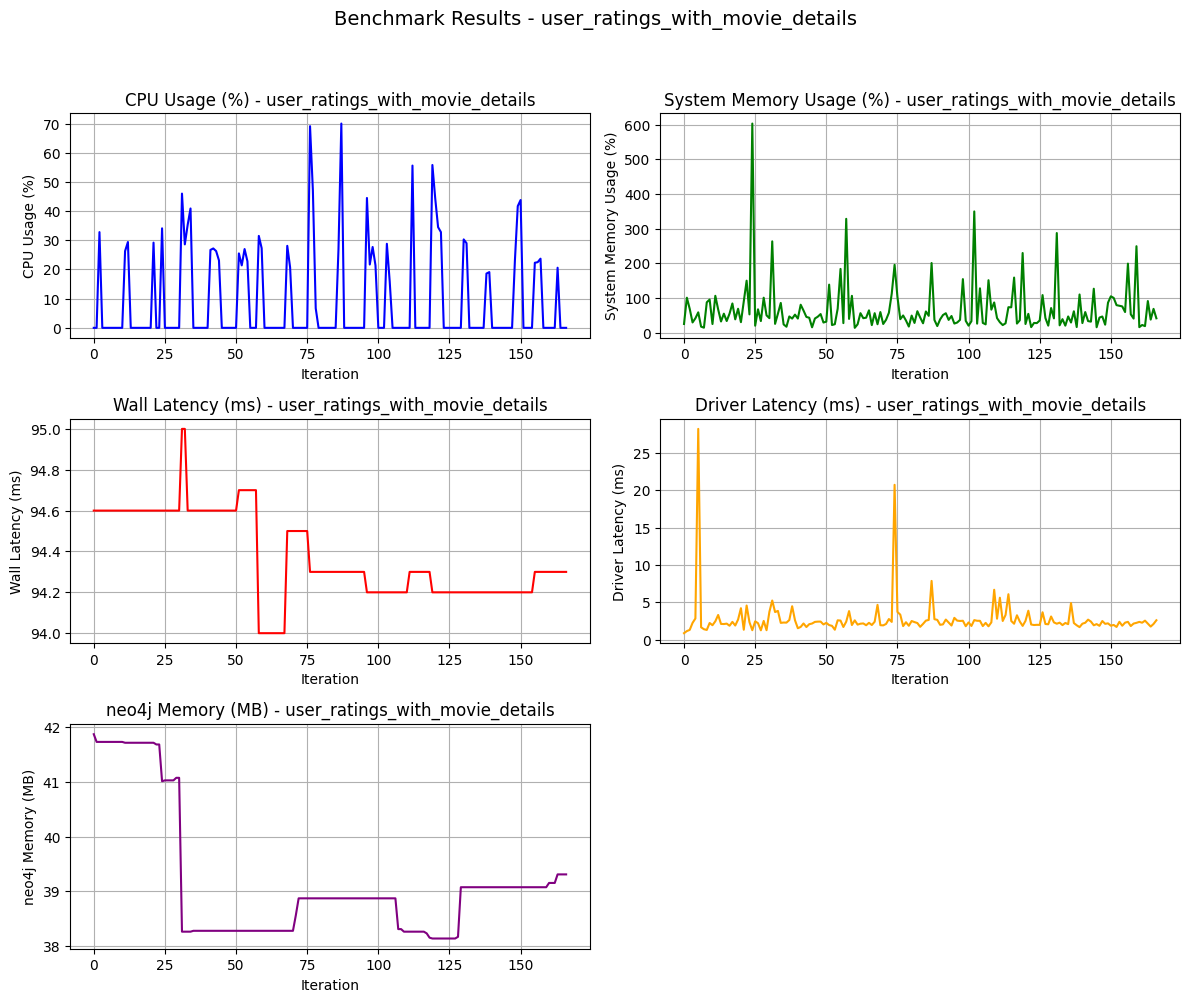

In [53]:
from src.benchmark.utils import plot_benchmark_results

plot_benchmark_results(
    query_id,
    result.series["sys_cpu_pct"],
    result.series["sys_mem_pct"],
    result.series["wall_ms"],    
    result.series["driver_ms"],
    neo4j_mem=result.series["neo4j_rss_mb"]
)

In [54]:
from src.benchmark.utils import generate_rand_movie_doc

generate_rand_movie_doc(random.randint(1, 10_000))

{'movieId': 3814,
 'title': 'Random Movie 3814',
 'year': 1995,
 'genres': ['Action', 'Comedy', 'Thriller'],
 'ratings': [{'userId': 232, 'rating': 5.0, 'timestamp': 1749544327},
  {'userId': 661, 'rating': 4.0, 'timestamp': 1747458632},
  {'userId': 53, 'rating': 3.5, 'timestamp': 1746181094},
  {'userId': 258, 'rating': 3.5, 'timestamp': 1745473152},
  {'userId': 711, 'rating': 1.0, 'timestamp': 1742624476},
  {'userId': 245, 'rating': 5.0, 'timestamp': 1748454823},
  {'userId': 566, 'rating': 2.5, 'timestamp': 1742469167},
  {'userId': 203, 'rating': 2.5, 'timestamp': 1749561466},
  {'userId': 732, 'rating': 3.0, 'timestamp': 1746363817},
  {'userId': 6, 'rating': 5.0, 'timestamp': 1742225010},
  {'userId': 390, 'rating': 3.5, 'timestamp': 1742102371},
  {'userId': 204, 'rating': 2.0, 'timestamp': 1747590467},
  {'userId': 497, 'rating': 4.0, 'timestamp': 1749653130},
  {'userId': 792, 'rating': 3.0, 'timestamp': 1745388030},
  {'userId': 441, 'rating': 5.0, 'timestamp': 1749929812}

In [55]:
# ----------- Write Operations -------------
def insert_single_movie():
    doc = generate_rand_movie_doc(random.randint(1, 10_000))
    with driver.session() as session:
        t0 = time.perf_counter_ns()
        session.run("""
            CREATE (m:Movie {
                movieId: $movieId,
                title: $title,
                year: $year,
                genres: $genres,
                avgRating: $avgRating,
                ratingCount: $ratingCount,
                ratingDistKeys: $ratingDistKeys,
                ratingDistValues: $ratingDistValues,
                tagIds: $tagIds,
                tagNames: $tagNames,
                tagRelevances: $tagRelevances
            })
        """, 
        movieId=doc["movieId"],
        title=doc["title"],
        year=doc["year"],
        genres=doc["genres"],
        avgRating=doc["stats"]["avgRating"],
        ratingCount=doc["stats"]["ratingCount"],
        ratingDistKeys=list(doc["stats"]["ratingDistribution"].keys()),
        ratingDistValues=list(doc["stats"]["ratingDistribution"].values()),
        tagIds=[tag["tagId"] for tag in doc["tagGenome"]],
        tagNames=[tag["tag"] for tag in doc["tagGenome"]],
        tagRelevances=[tag["relevance"] for tag in doc["tagGenome"]])
        driver_time_ns = time.perf_counter_ns() - t0
    return True, driver_time_ns

In [56]:
import time

def insert_multiple_movies():
    docs = [generate_rand_movie_doc(random.randint(1, 10_000)) for _ in range(5)]

    unwind_data = []
    for doc in docs:
        unwind_data.append({
            "movieId": doc["movieId"],
            "title": doc["title"],
            "year": doc["year"],
            "genres": doc["genres"],
            "avgRating": doc["stats"]["avgRating"],
            "ratingCount": doc["stats"]["ratingCount"],
            "ratingDistKeys": list(doc["stats"]["ratingDistribution"].keys()),
            "ratingDistValues": list(doc["stats"]["ratingDistribution"].values()),
            "tagIds": [tag["tagId"] for tag in doc["tagGenome"]],
            "tagNames": [tag["tag"] for tag in doc["tagGenome"]],
            "tagRelevances": [tag["relevance"] for tag in doc["tagGenome"]],
        })

    with driver.session() as session:
        t0 = time.perf_counter_ns()
        session.run("""
            UNWIND $batch AS movie
            CREATE (m:Movie {
                movieId: movie.movieId,
                title: movie.title,
                year: movie.year,
                genres: movie.genres,
                avgRating: movie.avgRating,
                ratingCount: movie.ratingCount,
                ratingDistKeys: movie.ratingDistKeys,
                ratingDistValues: movie.ratingDistValues,
                tagIds: movie.tagIds,
                tagNames: movie.tagNames,
                tagRelevances: movie.tagRelevances
            })
        """, batch=unwind_data)
        driver_time_ns = time.perf_counter_ns() - t0

    return True, driver_time_ns

In [57]:
from datetime import datetime

def insert_user_with_ratings():
    user_id = random.randint(1, 5_000)
    ratings = [{
        "movieId": random.randint(1, 1000),
        "rating": round(random.uniform(1.0, 5.0), 1),
        "timestamp": int(datetime.now().timestamp())
    } for _ in range(5)]

    with driver.session() as session:
        t0 = time.perf_counter_ns()

        # Create the User node
        session.run("""
            CREATE (u:User {
                userId: $userId,
                name: $name,
                ratingCount: $ratingCount
            })
        """, userId=user_id, name=f"User_{user_id}", ratingCount=len(ratings))

        # Create the RATED relationships
        for rating in ratings:
            session.run("""
                MERGE (m:Movie {movieId: $movieId})
                MERGE (u:User {userId: $userId})
                CREATE (u)-[:RATED {
                    rating: $rating,
                    timestamp: $timestamp
                }]->(m)
            """, movieId=rating["movieId"], userId=user_id,
                 rating=rating["rating"], timestamp=rating["timestamp"])

        driver_time_ns = time.perf_counter_ns() - t0

    return True, driver_time_ns

In [58]:
write_queries = [
    ("insert_single_movie", insert_single_movie),
    ("insert_multiple_movies", insert_multiple_movies),
    ("insert_user_with_ratings", insert_user_with_ratings),
]

for query_id, query_func in write_queries:
    result = run_benchmark(query_id, query_func, duration=20)
    print(f"{query_id} result summary:", result.summary)

insert_single_movie result summary: {'query': 'insert_single_movie', 'duration': 20, 'iterations': 308, 'successes': 308, 'errors': 0, 'wall_avg_ms': 10.967858087662337, 'wall_p95_ms': 14.978498100000001, 'wall_p99_ms': 19.06215869, 'driver_avg_ms': 4.858222954545455, 'driver_p95_ms': 7.4890519000000015, 'driver_p99_ms': 11.571505559999999, 'cpu_avg_pct': 4.878896103896104, 'cpu_p95_pct': 30.51, 'cpu_p99_pct': 49.928000000000004, 'sys_mem_avg_pct': 94.26525974025974, 'sys_mem_p95_pct': 94.4, 'sys_mem_p99_pct': 94.5, 'neo4j_rss_avg_mb': 39.63813920454545, 'neo4j_rss_p95_mb': 40.078125, 'neo4j_rss_p99_mb': 40.078125, 'major_faults_per_sec': 0.0, 'throughput_qps': 15.4}
insert_multiple_movies result summary: {'query': 'insert_multiple_movies', 'duration': 20, 'iterations': 282, 'successes': 282, 'errors': 0, 'wall_avg_ms': 17.09783964893617, 'wall_p95_ms': 21.295001799999998, 'wall_p99_ms': 27.285355359999997, 'driver_avg_ms': 7.546970453900709, 'driver_p95_ms': 9.46686605, 'driver_p99_ms

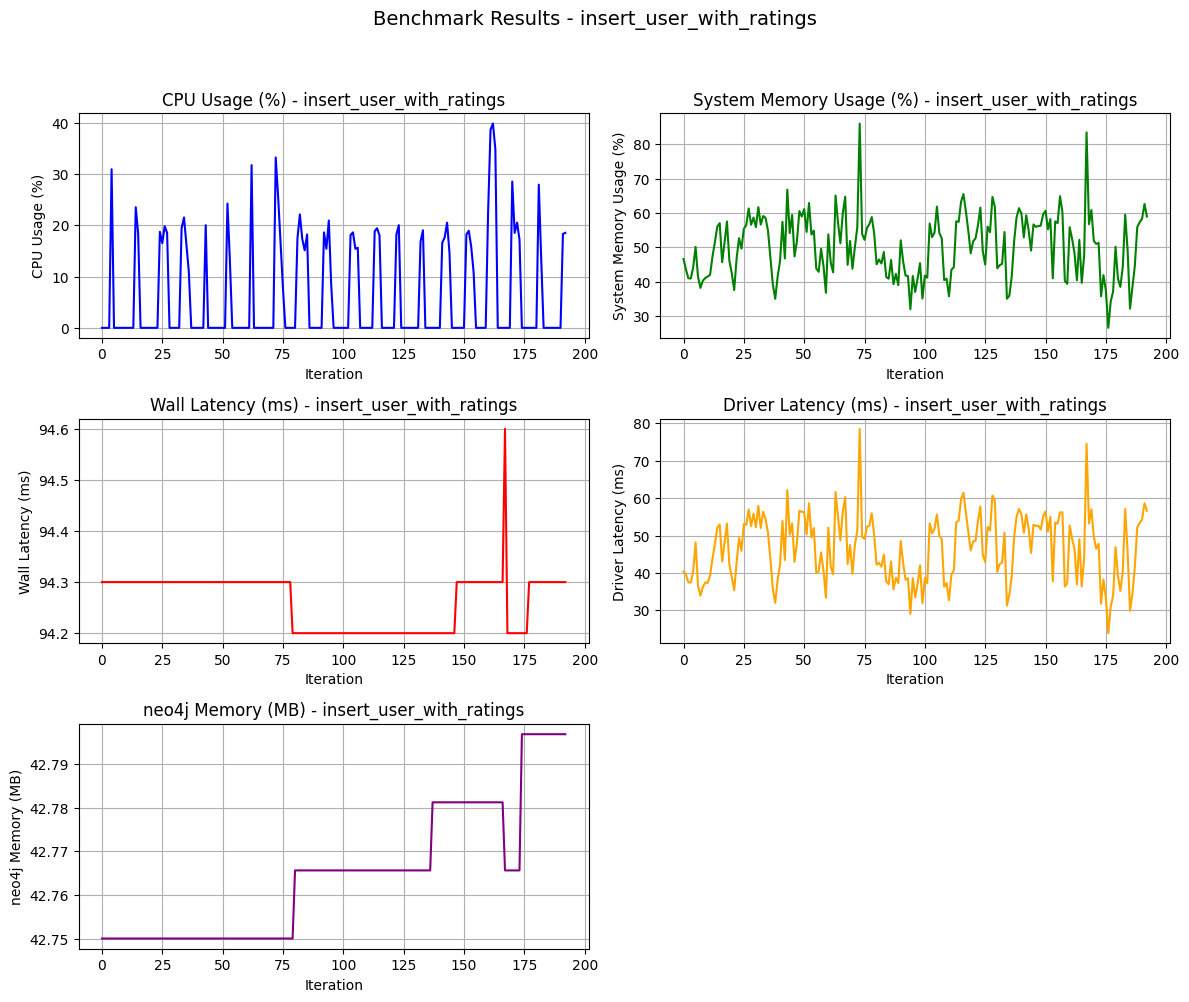

In [59]:
from src.benchmark.utils import plot_benchmark_results

plot_benchmark_results(
    query_id,
    result.series["sys_cpu_pct"],
    result.series["sys_mem_pct"],
    result.series["wall_ms"],    
    result.series["driver_ms"],
    neo4j_mem=result.series["neo4j_rss_mb"]
)

In [60]:
import numpy as np

USER_SAMPLE_SIZE = 500
SAMPLE_POOL = list(np.random.choice(selected_users, size=USER_SAMPLE_SIZE, replace=False))

In [61]:
# ----------- Update Operations -------------
def update_user_rating_timestamps():
    user_id = SAMPLE_POOL.pop()
    
    with driver.session() as session:
        t0 = time.perf_counter_ns()

        session.run("""
            MATCH (u:User {userId: $userId})-[r:RATED]->(:Movie)
            SET r.timestamp = datetime({ epochSeconds: r.timestamp })
        """, userId=user_id)

        driver_time_ns = time.perf_counter_ns() - t0

    return True, driver_time_ns

In [62]:
update_queries = [
    ("update_user_rating_timestamps", update_user_rating_timestamps)
]

for query_id, query_func in update_queries:
    result = run_benchmark(query_id, query_func, duration=20)
    print(f"{query_id} result summary:", result.summary)

update_user_rating_timestamps result summary: {'query': 'update_user_rating_timestamps', 'duration': 20, 'iterations': 290, 'successes': 290, 'errors': 0, 'wall_avg_ms': 15.227980144827587, 'wall_p95_ms': 45.8140337, 'wall_p99_ms': 57.58746641, 'driver_avg_ms': 9.236530024137931, 'driver_p95_ms': 33.924987800000004, 'driver_p99_ms': 46.632055, 'cpu_avg_pct': 7.666896551724138, 'cpu_p95_pct': 40.660000000000004, 'cpu_p99_pct': 84.25200000000001, 'sys_mem_avg_pct': 94.1303448275862, 'sys_mem_p95_pct': 94.4, 'sys_mem_p99_pct': 94.5, 'neo4j_rss_avg_mb': 43.220905172413794, 'neo4j_rss_p95_mb': 46.59375, 'neo4j_rss_p99_mb': 47.90625, 'major_faults_per_sec': 0.0, 'throughput_qps': 14.5}


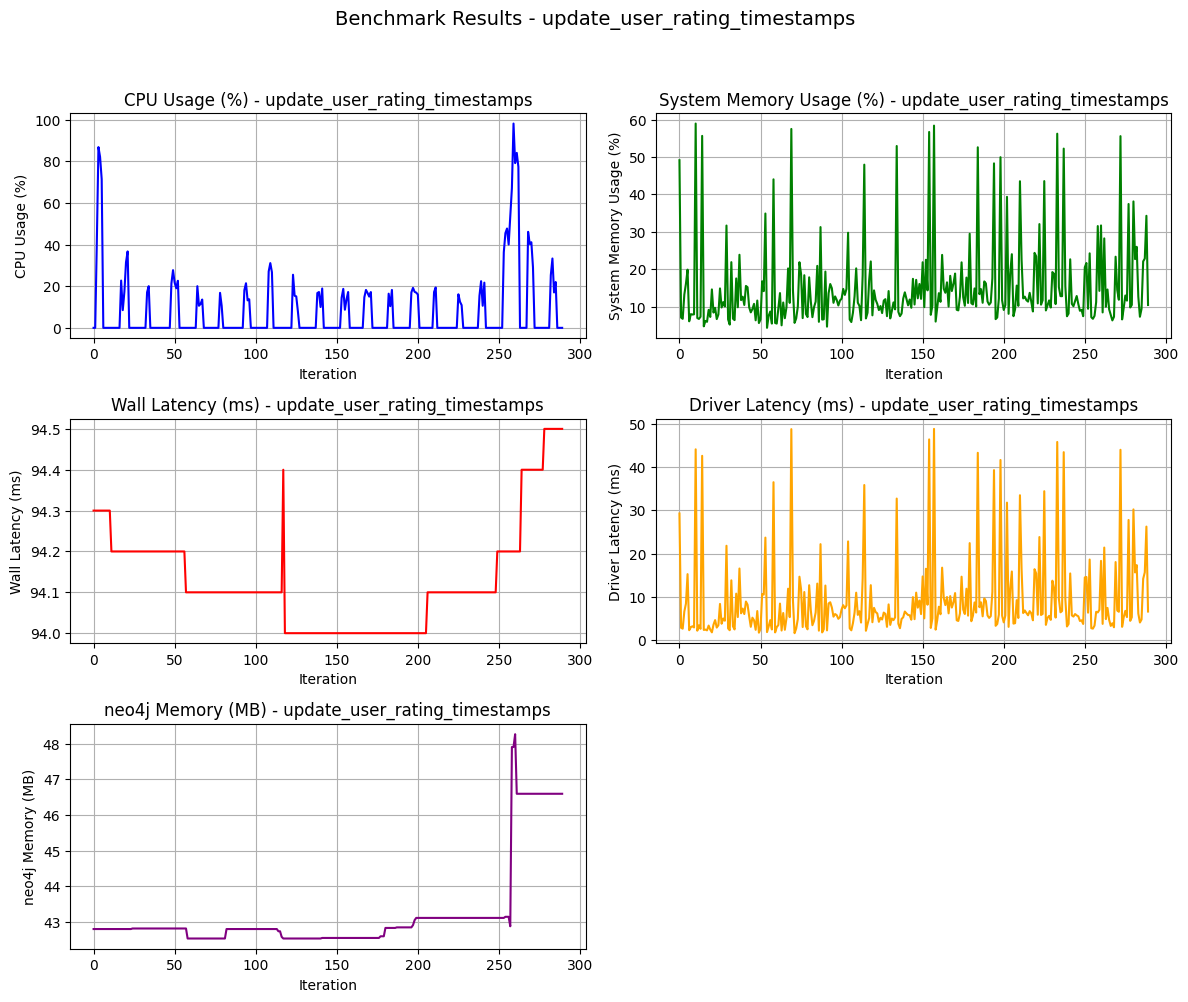

In [63]:
from src.benchmark.utils import plot_benchmark_results

plot_benchmark_results(
    query_id,
    result.series["sys_cpu_pct"],
    result.series["sys_mem_pct"],
    result.series["wall_ms"],    
    result.series["driver_ms"],
    neo4j_mem=result.series["neo4j_rss_mb"]
)